In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing

import time

df=pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
print(df.info())
# From the data info, we can infer that there are no null values in the dataset at all.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Looking at Outliers

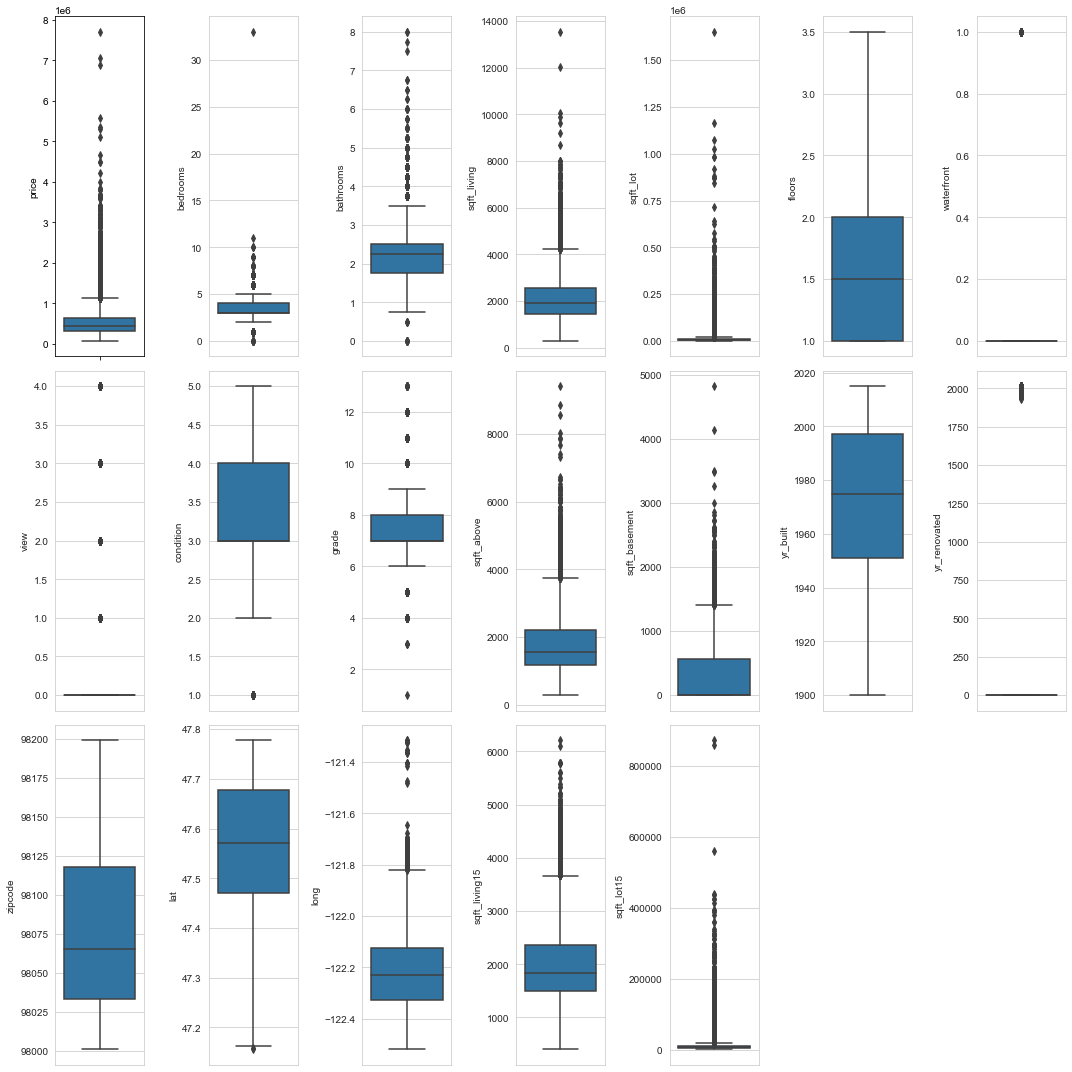

In [5]:
df_boxplot = df.drop(columns=['id','date'])
l = df_boxplot.columns.values
number_of_columns=19
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(15,15))
for i in range(0,len(l)):
    plt.subplot(3,7,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y =df_boxplot[l[i]],data = df_boxplot)
    plt.tight_layout()

Looking at the boxplots, we can see that some features are continuous while others are discrete.

Although there are outliers, I will not be removing the outliers as there are reasons for these outliers. For example, there is a house priced nearly at 8000000. However, this outlier corresponds to the outlier in the number of bedrooms which is 30+ and it has 1 waterfront which is the only house that has a waterfront. This outlier can be useful for the model in predicting houses that have similar number of bedrooms or waterfronts. 

## Correlation between variables

In [6]:
# Dropping id as it only acts as a unique identification of  houses.
df.drop(columns=['id'] , inplace = True)

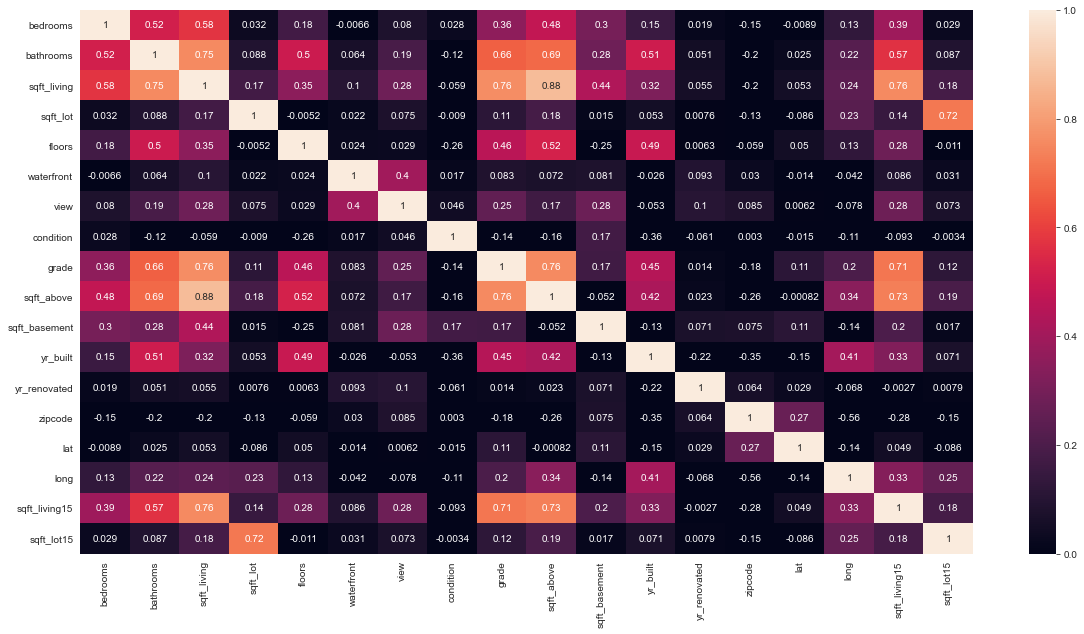

In [7]:
# Using seaborn heatmap to create a heatmap for the correlation between all independent features.
plt.figure(figsize=(20, 10))
sns.heatmap(pd.DataFrame(df.corr().iloc[1:,1:]), vmin=0, vmax=1, annot=True)
plt.show()

Now, examine the independent variables correlation with dependent variable 'price'

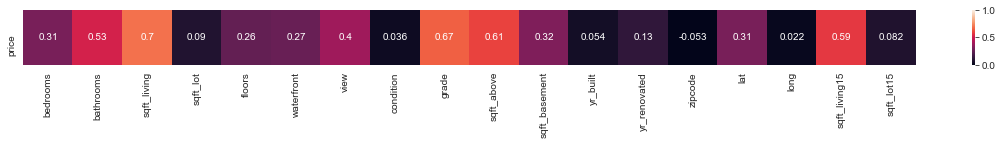

In [8]:
# Using seaborn heatmap to create a heatmap for the correlation between dependent variable with independent variable.
plt.figure(figsize=(20, 1))
sns.heatmap(pd.DataFrame(df.corr().iloc[0,1:]).T, vmin=0, vmax=1, annot=True)
plt.show()

These are the features that are more strongly correlated (>0.5) with price than other featres are:
- <font color='orange'>bathrooms</font>
- <font color='green'>sqft_living</font>
- <font color='blue'>grade</font>
- <font color='purple'>sqft_above</font>
- <font color='red'>sqft_living15</font>

Looking at the bigger heatmap that shows the correlation between independent features, the correlation between the independent features are:

- <font color='orange'>bathrooms</font> are correlated to <font color='green'>sqft_living</font>, <font color='blue'>grade</font>, <font color='purple'>sqft_above</font>
- <font color='green'>sqft_living</font> are correlated to <font color='blue'>grade</font>, <font color='purple'>sqft_above</font>, <font color='red'>sqft_living15</font>
- sqft_lot are correlated to sqft_lot15
- <font color='blue'>grade</font> are correlated to <font color='purple'>sqft_above</font>, <font color='green'>sqft_living</font>
- <font color='purple'>sqft_above</font> are correlated to <font color='red'>sqft_living15</font>

The above shows that the color coded features are the features that are correlated to price and also correlated to the other features that are correlated to price as well. For example, the price of the house is increased when the grade and square footage of interior living space is higher. However, grade and interior living space are also correlated. In this case, we cannot use linear regression or multi linear regression for the models as multicollinearity is present.

I can either remove some of the highly correlated independent variables or use ridge regression.

# Baseline Model: Ridge Regression Model
I used Ridge Regression as the baseline model because multicollinearity is present and Ridge regression is a model that handles 
multicollinearity well

In [9]:
# Defining features and target
X = df.drop(columns=['price','date'])
y = df['price']
# Scaling the feature and target values as values have different magnitude
X = preprocessing.scale(X)
y = preprocessing.scale(y)
# Spliting the data into a train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [78]:
# Initializing Ridge model
ridge_reg = Ridge()
# Scoring metrics
scoring = ['neg_mean_squared_error','r2', 'neg_mean_absolute_error']

# Using 5 fold cross to get a bunch of results so that the performance of the model would fairer
baseline_cvscores = cross_validate(ridge_reg, X, y, scoring=scoring, cv = 5, return_train_score= True, return_estimator=True)

coeff = pd.DataFrame(columns=df.drop(columns=['price','date']).columns)
r2_train = baseline_cvscores['train_r2']
mse = baseline_cvscores['test_neg_mean_squared_error']*-1 # Multiplying -1 as  'neg_mean_squared_error' returns negative MSE
rmse = np.sqrt(mse)
mae = baseline_cvscores['test_neg_mean_absolute_error']*-1 # Multiplying -1 as  'neg_mean_absolute_error' returns negative MAE
r2 = baseline_cvscores['test_r2']
for model in baseline_cvscores['estimator']:
    coeff.loc[len(coeff)] =  model.coef_

print(f'R squared of each train fold: {r2_train}')
print(f'Average R Squared of 5 train folds: {np.mean(r2_train)} \n')

print(f'R squared of each test fold: {r2}')
print(f'Average R Squared of 5 test folds: {np.mean(r2)} \n')

print(f'MAE of each test fold: {mae}')
print(f'Average MAE of 5 test folds: {np.mean(mae)} \n')

print(f'MSE of each test fold: {mse}')
print(f'Average MSE of 5 test folds: {np.mean(mse)} \n')

print(f'RMSE of each test fold: {rmse}')
print(f'Average RMSE of 5 test folds: {np.mean(rmse)} \n')
mean_coeff = pd.DataFrame(data=coeff.mean(), index=df.drop(columns=['price','date']).columns)
print(mean_coeff.sort_values(mean_coeff.columns[0], ascending = False))

R squared of each train fold: [0.70023823 0.70173581 0.70086698 0.69731728 0.70090241]
Average R Squared of 5 train folds: 0.7002121439117086 

R squared of each test fold: [0.69615521 0.69102985 0.69273538 0.70769756 0.68534154]
Average R Squared of 5 test folds: 0.6945919093569903 

MAE of each test fold: [0.35190007 0.34131939 0.33015563 0.34815186 0.35746216]
Average MAE of 5 test folds: 0.3457978231261353 

MSE of each test fold: [0.34149351 0.32146532 0.26632081 0.27529901 0.3206975 ]
Average MSE of 5 test folds: 0.3050552291352974 

RMSE of each test fold: [0.58437446 0.56697912 0.51606279 0.52468944 0.5663016 ]
Average RMSE of 5 test folds: 0.5516814820569995 

                      0
grade          0.306407
lat            0.227262
sqft_living    0.223122
sqft_above     0.208315
waterfront     0.137315
view           0.110372
bathrooms      0.086402
sqft_basement  0.073255
condition      0.046693
sqft_living15  0.041368
yr_renovated   0.021579
sqft_lot       0.014416
floors    

The Ridge Regression model explains 69% of the fitted data. 

Mean MAE Score of 0.3 tells us that average error (absolute difference between predicted scaled price and true scaled price) is 0.3.

The mean MSE score is 0.3.

The mean RMSE score is 0.55 which means the standard deviation of the error when a price is predicted.

## Improving the model
For the actual model, I will be using Bagging regressor that is an ensemble method. This model would take a bit of time as the  number of base estimators is big.

In [100]:
start_time = time.time()
bagging_reg = BaggingRegressor()
param_grid = {'n_estimators' : [10,50,100,200]}
bagging_grid = GridSearchCV(bagging_reg, param_grid, scoring='neg_mean_squared_error',cv=5)
bagging_grid.fit(X_train, y_train)   
print('Best parameters: ',bagging_grid.best_params_)


bagging_reg = BaggingRegressor(n_estimators =  200)
bagging_reg.fit(X_train, y_train)   
y_pred = bagging_reg.predict(X_test)   

r2 = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print('R square score: ',r2)
print('MAE score: ',mae)
print('MSE score: ',mse)
print('RMSE score: ',rmse)

end_time = time.time()
print('Time taken: ', end_time-start_time)

Best parameters:  {'n_estimators': 100}
R square score:  0.8822891931456684
MAE score:  0.18979093274269762
MSE score:  0.12059358651124558
RMSE score:  0.34726587294354966
Time taken:  181.0674443244934


The R square scores shows that 88% of the variance in the price that can be explained by the features.

The MAE score is 0.189 which means that the average error is now smaller. The predicted price is closer to the actual values of price as compared to the predictions of the baseline model.

The MSE is 0.12. I included outliers so MSE is useful in this case. 

The RMSE is 0.34 which is lower than the RMSE of the baseline model. The standard deviation of the errors is smaller which means the predicted data points would be closer to the true values.

In summary, bagging regressor performed better than Ridge Regression.